## Imports and utils

In [1]:
import networkx as nx
import csv
import time
import pandas as pd
from cdlib import algorithms, readwrite, evaluation, NodeClustering
from cdlib.benchmark import LFR, SBM, GRP
import infomap
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from pathlib import Path

In [2]:
figurePath = Path("Figures")
print(figurePath)

Figures


In [3]:
def datafileToGraph(fileName):
    emailRaw = pd.read_csv(fileName, header=None)
    emailRaw = emailRaw[0].str.split(n=2, expand=True)
    emailRaw.columns = ['Source', 'Target']
    #print(emailRaw)
    emailNetwork = nx.from_pandas_edgelist(emailRaw, source='Source', target='Target', edge_attr=None)
    #nx.draw(emailNetwork)  
    emailNetwork.name = fileName.split(".")[0]
    return emailNetwork
emailNet = datafileToGraph('emailNet.txt')
print(emailNet)

Graph named 'emailNet' with 1005 nodes and 16706 edges


In [4]:
def averageDegree(networkx):
    degrees = [val for (node, val) in networkx.degree()]
    sum = 0
    for d in degrees:
        sum += d
    return sum/len(degrees)

In [5]:
def new_infomap(g_original: object, flags: str = "") -> NodeClustering:
    
    g1 = nx.convert_node_labels_to_integers(g_original, label_attribute="name")
    name_map = nx.get_node_attributes(g1, "name")
    coms_to_node = defaultdict(list)
    
    flags += " --silent"

    im = infomap.Infomap(flags)

    im.add_nodes(g_original.nodes)

    for source, target, data in g1.edges(data=True):
        if "weight" in data:
            im.add_link(source, target, data["weight"])
        else:
            im.add_link(source, target)
    im.run()

    for node_id, module_id in im.modules:
        node_name = name_map[node_id]
        coms_to_node[module_id].append(node_name)

    coms_infomap = [list(c) for c in coms_to_node.values()]
    
    return NodeClustering(
        coms_infomap, g_original, "Infomap", method_parameters={"flags": flags}
    )

## Email network properties 

In [6]:
#print("Degree distribution:", nx.degree_histogram(emailNet))
print("Average degree:", averageDegree(emailNet))
print("Clustering coefficient:", nx.average_clustering(emailNet))

for C in (emailNet.subgraph(c) for c in nx.connected_components(emailNet)):
    print("Average Path Length:", nx.average_shortest_path_length(C))
    break



#centrality
#plot deggre centrality
fig = plt.figure(figsize=(3*1.61803398875, 3))
ax = plt.axes((0.2, 0.2, 0.70, 0.70), facecolor='w')
d = np.array(nx.degree_histogram(emailNet))
y = d / len(emailNet.nodes)
x = np.arange(len(y))
ax.plot(x,y,"go")
ax.set_xlabel("k")
ax.set_ylabel("Pk")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title("Degree distribution")
#ax.legend()
fig.savefig(figurePath/("DegreeDistribution_%s.png" % (emailNet.name)))
plt.close(fig)


Average degree: 33.245771144278606
Clustering coefficient: 0.3993549664221539
Average Path Length: 2.586933824816466


## Community finding methods for the email network

In [37]:
algs = ["louvain", "leiden", "girvan_newman"]
timeArray = []

start_time = time.time()
emailLouvain = algorithms.louvain(emailNet)
t = time.time() - start_time
print("Execution time for Louvain in email net: %.6s seconds" % (t))
timeArray.append(round(t,6))

start_time = time.time()
emailLeiden = algorithms.leiden(emailNet)
t = time.time() - start_time
print("Execution time for Leiden in email net: %.6s seconds" % (t))
timeArray.append(round(t,6))

start_time = time.time()
emailGN = algorithms.girvan_newman(emailNet, level=3)
t = time.time() - start_time
print("Execution time for Girvan-Newman in email net: %.6s seconds" % (t))
timeArray.append(round(t,6))

      
#start_time = time.time()
#emailKC = algorithms.kclique(emailNet, k=10)
#print("Execution time for KCliques in email net: %.6s seconds" % (time.time() - start_time))
#print("Execution time for Infomap in email net: %.6s seconds" % (time.time() - start_time))
      
fig = plt.figure(figsize=(3*1.61803398875, 3))
ax = plt.axes((0.2, 0.2, 0.70, 0.70), facecolor='w')

width = 3.2 / (len(algs)*len(timeArray))  # the width of the bars
step = width / len(algs)

for alg_id in range(len(algs)):
    ax.bar(algs[alg_id], timeArray[alg_id], step, label=algs[alg_id])
      
ax.set_ylabel("Execution time")
ax.set_title("Execution time")
fig.savefig(figurePath/("Execution_Time%s.png" % (emailNet.name)))
plt.close(fig)

Execution time for Louvain in email net: 0.4338 seconds
Execution time for Leiden in email net: 0.0438 seconds
Execution time for Girvan-Newman in email net: 117.08 seconds


## Louvain properties

In [34]:
nComs = list(emailLouvain.to_node_community_map().values())[-1][0]+1
size = evaluation.size(emailNet, emailLouvain)
ad = evaluation.avg_distance(emailNet, emailLouvain)
aid = evaluation.average_internal_degree(emailNet, emailLouvain)
ae = evaluation.avg_embeddedness(emailNet, emailLouvain)
at = evaluation.avg_transitivity(emailNet, emailLouvain)
hd = evaluation.hub_dominance(emailNet, emailLouvain)

print("Louvain Number of communities:", nComs)
print("Louvain Average Community Size:", size)
print("Louvain Average Path Length:",  ad)
print("Louvain Average Internal Degree:",  aid)
print("Louvain Average Embeddedness:",  ae)
print("Louvain Average Transitivity:",  at)
print("Louvain Hub Dominance:",  hd)

Louvain Number of communities: 28
Louvain Average Community Size: FitnessResult(min=1, max=242, score=35.892857142857146, std=61.7525819504822)
Louvain Average Path Length: FitnessResult(min=0, max=2.3587693798449614, score=0.6687511989004468, std=0.9814561549961194)
Louvain Average Internal Degree: FitnessResult(min=2.0, max=26.414414414414413, score=7.1414264044270235, std=8.145409774820516)
Louvain Average Embeddedness: FitnessResult(min=0.5262840971085652, max=1.0, score=0.9026454393768262, std=0.1511494864953937)
Louvain Average Transitivity: FitnessResult(min=0.0, max=0.7483573148327239, score=0.17693456966841095, std=0.26202897409459874)
Louvain Hub Dominance: FitnessResult(min=0.42323651452282157, max=1.1111111111111112, score=0.6302828175082392, std=0.1938634867901892)
Louvain Significance: FitnessResult(min=None, max=None, score=61545.919858859335, std=None)


In [9]:
#louvainDict = louvain.to_node_community_map()
#print(louvainDict)
#louvain.to_json()

## Leiden 

In [36]:
nComs = list(emailLeiden.to_node_community_map().values())[-1][0]+1
size = evaluation.size(emailNet, emailLeiden)
ad = evaluation.avg_distance(emailNet, emailLeiden)
aid = evaluation.average_internal_degree(emailNet, emailLeiden)
ae = evaluation.avg_embeddedness(emailNet, emailLeiden)
at = evaluation.avg_transitivity(emailNet, emailLeiden)
hd = evaluation.hub_dominance(emailNet, emailLeiden)

print("Leiden Number of communities:", nComs)
print("Leiden Average Community Size:", size)
print("Leiden Average Path Length:",  ad)
print("Leiden Average Internal Degree:",  aid)
print("Leiden Average Embeddedness:",  ae)
print("Leiden Average Transitivity:",  at)
print("Leiden Hub Dominance:",  hd)

Leiden Number of communities: 27
Leiden Average Community Size: FitnessResult(min=1, max=245, score=37.22222222222222, std=62.93637782968597)
Leiden Average Path Length: FitnessResult(min=0, max=2.377818668450987, score=0.6413249932430524, std=0.9921364087509856)
Leiden Average Internal Degree: FitnessResult(min=2.0, max=25.0990990990991, score=7.1751057028643785, std=8.2048837020894)
Leiden Average Embeddedness: FitnessResult(min=0.5497627459803758, max=1.0, score=0.9175145392570943, std=0.13331845281395657)
Leiden Average Transitivity: FitnessResult(min=0.0, max=0.7730782353499883, score=0.15939350931645443, std=0.25158624800626506)
Leiden Hub Dominance: FitnessResult(min=0.4057377049180328, max=0.6363636363636364, score=0.5550471907298913, std=0.07580252489705826)


## Girvan-Newman

In [38]:
nComs = list(emailGN.to_node_community_map().values())[-1][0]+1
size = evaluation.size(emailNet, emailGN)
ad = evaluation.avg_distance(emailNet, emailGN)
aid = evaluation.average_internal_degree(emailNet, emailGN)
ae = evaluation.avg_embeddedness(emailNet, emailGN)
at = evaluation.avg_transitivity(emailNet, emailGN)
hd = evaluation.hub_dominance(emailNet, emailGN)

print("Girvan-Newman Number of communities:", nComs)
print("Girvan-Newman Size:", size)
print("Girvan-Newman Average Path Length:",  ad)
print("Girvan-Newman Average Internal Degree:",  aid)
print("Girvan-Newman Average Embeddedness:",  ae)
print("Girvan-Newman Average Transitivity:",  at)
print("Girvan-Newman Hub Dominance:",  hd)

Girvan-Newman Number of communities: 23
Girvan-Newman Size: FitnessResult(min=1, max=978, score=43.69565217391305, std=199.1969605981256)
Girvan-Newman Average Path Length: FitnessResult(min=0, max=2.5665982212565908, score=0.1927506473010112, std=0.6330518282579853)
Girvan-Newman Average Internal Degree: FitnessResult(min=0.0, max=34.08997955010225, score=3.235796212323286, std=6.602873143511623)
Girvan-Newman Average Embeddedness: FitnessResult(min=0.0, max=1.0, score=0.9057542629926452, std=0.2815706562689681)
Girvan-Newman Average Transitivity: FitnessResult(min=0.0, max=0.4108588094169628, score=0.017863426496389688, std=0.08378689716311363)
Girvan-Newman Hub Dominance: FitnessResult(min=0.35516888433981575, max=1.2, score=0.7775844421699079, std=0.4224155578300921)
Girvan-Newman Significance: FitnessResult(min=None, max=None, score=78331.79378130106, std=None)


## Modularity

In [11]:
louvainGN = evaluation.newman_girvan_modularity(emailNet, emailLouvain)
louvainER = evaluation.erdos_renyi_modularity(emailNet, emailLouvain)
louvainZ = evaluation.z_modularity(emailNet, emailLouvain)

print("Louvain Girvan-Newman mod:", louvainGN)
print("Louvain Erdos-Renyi mod:", louvainER)
print("Louvain Z-mod:", louvainZ)

Louvain Girvan-Newman mod: FitnessResult(min=None, max=None, score=0.4326447395710833, std=None)
Louvain Erdos-Renyi mod: FitnessResult(min=None, max=None, score=0.45046874723811403, std=None)
Louvain Z-mod: FitnessResult(min=None, max=None, score=1.1869576999709814, std=None)


## External Evaluation

In [12]:
nmi = evaluation.normalized_mutual_information(emailLouvain, emailGN)
ami = evaluation.adjusted_mutual_information(emailLouvain, emailGN)
ari = evaluation.adjusted_rand_index(emailLouvain, emailGN)
f1 = evaluation.f1(emailLouvain, emailGN)
voi = evaluation.variation_of_information(emailLouvain, emailGN)

print("Normalized Mutual Information between Louvain and Girvan-Newman:", nmi)
print("Adjusted Mutual Information between Louvain and Girvan-Newman:", ami)
print("Adjusted Rand Index between Louvain and Girvan-Newman:", ari)
print("F1 measure between Louvain and Girvan-Newman:", f1)
print("Variation of information between Louvain and Girvan-Newman:", voi)

Normalized Mutual Information between Louvain and Girvan-Newman: MatchingResult(score=0.14375880880788014, std=None)
Adjusted Mutual Information between Louvain and Girvan-Newman: MatchingResult(score=0.10574826763710264, std=None)
Adjusted Rand Index between Louvain and Girvan-Newman: MatchingResult(score=0.01346971650042717, std=None)
F1 measure between Louvain and Girvan-Newman: MatchingResult(score=0.7685185185185185, std=0.3593585200789885)
Variation of information between Louvain and Girvan-Newman: MatchingResult(score=2.854934021362194, std=None)


## Email Labels import 

In [39]:
def convertTextDatasetToCSV(txtFile, csvFile):
    txtFile = open(txtFile, 'r')
    
    txtLines = txtFile.readlines()
    csvLines = {}
    
    for line in txtLines:
        lineVec = line[:-1].split(' ')
        if lineVec[1] in csvLines.keys():
            csvLines[lineVec[1]].append(lineVec[0])
        else:
            csvLines[lineVec[1]] = [lineVec[0]]
            
    with open(csvFile, 'w',newline="") as csv_file:  
        writer = csv.writer(csv_file)
        for key, value in csvLines.items():
            writer.writerow(value)
        
convertTextDatasetToCSV('emailLabels.txt', 'emailLabels.csv')
emailLabels = readwrite.read_community_csv("emailLabels.csv", ",", str)

In [40]:
nmiLouvainLabels = emailLouvain.normalized_mutual_information(emailLabels)
nmiLeidenLabels = emailLeiden.normalized_mutual_information(emailLabels)
nmiGirvanNewmanLabels = emailGN.normalized_mutual_information(emailLabels)

amiLouvainLabels = emailLouvain.adjusted_mutual_information(emailLabels)
amiLeidenLabels = emailLeiden.adjusted_mutual_information(emailLabels)
amiGirvanNewmanLabels = emailGN.adjusted_mutual_information(emailLabels)

ariLouvainLabels = emailLouvain.adjusted_rand_index(emailLabels)
ariLeidenLabels = emailLeiden.adjusted_rand_index(emailLabels)
ariGirvanNewmanLabels = emailGN.adjusted_rand_index(emailLabels)

f1LouvainLabels = emailLouvain.f1(emailLabels)
f1LeidenLabels = emailLeiden.f1(emailLabels)
f1GirvanNewmanLabels = emailGN.f1(emailLabels)

voiLouvainLabels = emailLouvain.variation_of_information(emailLabels)
voiLeidenLabels = emailLeiden.variation_of_information(emailLabels)
voiGirvanNewmanLabels = emailGN.variation_of_information(emailLabels)

print("NMI for Louvain and labels:", nmiLouvainLabels)
print("NMI for Leiden and labels:", nmiLeidenLabels)
print("NMI for Girvan-Newman and labels:", nmiGirvanNewmanLabels)
print()
print("AMI for Louvain and labels:", amiLouvainLabels)
print("AMI for Leiden and labels:", amiLeidenLabels)
print("AMI for Girvan-Newman and labels:", amiGirvanNewmanLabels)
print()
print("ARI for Louvain and labels:", ariLouvainLabels)
print("ARI for Leiden and labels:", ariLeidenLabels)
print("NMI for Girvan-Newman and labels:", ariGirvanNewmanLabels)
print()
print("F1 for Louvain and labels:", f1LouvainLabels)
print("F1 for Leiden and labels:", f1LeidenLabels)
print("F1 for Girvan-Newman and labels:", f1GirvanNewmanLabels)
print()
print("VOI for Louvain and labels:", voiLouvainLabels)
print("VOI for Leiden and labels:", voiLeidenLabels)
print("VOI for Girvan-Newman and labels:", voiGirvanNewmanLabels)

NMI for Louvain and labels: MatchingResult(score=0.5882969131854163, std=None)
NMI for Leiden and labels: MatchingResult(score=0.5776771281141226, std=None)
NMI for Girvan-Newman and labels: MatchingResult(score=0.0449480988954229, std=None)

AMI for Louvain and labels: MatchingResult(score=0.5527517337989198, std=None)
AMI for Leiden and labels: MatchingResult(score=0.540992332601562, std=None)
AMI for Girvan-Newman and labels: MatchingResult(score=-0.0005067215292382119, std=None)

ARI for Louvain and labels: MatchingResult(score=0.3311391803457487, std=None)
ARI for Leiden and labels: MatchingResult(score=0.2985758824644375, std=None)
NMI for Girvan-Newman and labels: MatchingResult(score=-0.0012481583268392242, std=None)

F1 for Louvain and labels: MatchingResult(score=0.21592592592592594, std=0.2803999690819878)
F1 for Leiden and labels: MatchingResult(score=0.2082142857142857, std=0.27508509815053567)
F1 for Girvan-Newman and labels: MatchingResult(score=0.05695652173913045, std=

## LFR 

In [29]:
n = 500
tau1 = 3
tau2 = 1.5
#mu = 0.1
mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
b = "LFR"

resultsLouvain = []
resultsLeiden = []
resultsInfomap = []
resultsGN = []

for mu in tqdm(mus):
    lfrGraph, comsLFR = LFR(n, tau1, tau2, mu, average_degree=5, min_community=20)
    
    lfrLouvain = algorithms.louvain(lfrGraph)
    lfrLeiden = algorithms.leiden(lfrGraph)
    lfrInfomap = new_infomap(lfrGraph, "-N 2")
    lfrGN = algorithms.girvan_newman(lfrGraph, level=3)
    
    nmi1 = evaluation.normalized_mutual_information(lfrLouvain, comsLFR)
    resultsLouvain.append(nmi1[0])
    nmi2 = evaluation.normalized_mutual_information(lfrLeiden, comsLFR)
    resultsLeiden.append(nmi2[0])
    nmi3 =  evaluation.normalized_mutual_information(lfrInfomap, comsLFR)
    resultsInfomap.append(nmi3[0])
    nmi4 =  evaluation.normalized_mutual_information(lfrGN, comsLFR)
    resultsGN.append(nmi4[0])
    

fig = plt.figure(figsize=(3*1.61803398875, 3))
ax = plt.axes((0.2, 0.2, 0.70, 0.70), facecolor='w')

ax.plot(mus,resultsLouvain, "-ro", label = "Louvain")
ax.plot(mus,resultsLeiden, "-go", label = "Leiden")
ax.plot(mus,resultsInfomap, "-bo", label = "Infomap")
ax.plot(mus,resultsGN, "-yo", label = "Girvan-Newman")

ax.set_xlabel(chr(945+11))
ax.set_ylabel("Performance")
ax.set_title("nmi Accuracy")
ax.legend()
fig.savefig(figurePath/("Benchmark_Results_%s.png" % (b)))
plt.close(fig)

100%|██████████| 7/7 [09:30<00:00, 81.54s/it]


## Best Girvan-Newman for LFR

In [45]:
lfr, _ = LFR(500, 3, 1.5, 0.1, average_degree=5, min_community=20)
levels = [17, 20 ,25]

for l in tqdm(levels):
    lfrGN = algorithms.girvan_newman(lfr, l)
    print("GN mod for level %d:" % (l), evaluation.newman_girvan_modularity(lfr,lfrGN))

 33%|███▎      | 1/3 [00:30<01:01, 30.72s/it]

GN mod for level 17: FitnessResult(min=None, max=None, score=0.8646771914429044, std=None)


 67%|██████▋   | 2/3 [01:02<00:31, 31.55s/it]

GN mod for level 20: FitnessResult(min=None, max=None, score=0.8542455535440362, std=None)


100%|██████████| 3/3 [01:36<00:00, 32.31s/it]

GN mod for level 25: FitnessResult(min=None, max=None, score=0.8349831919127709, std=None)


## SBM 

In [30]:
resultsLouvain = []
resultsLeiden = []
resultsInfomap = []
resultsGN = []
b = "SBM"

mus = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

sizes = [32, 32, 32, 32]
for c in tqdm(mus):
    probs = [[1-c, c, c, c], [c, 1-c, c, c], [c, c, 1-c, c],[c, c, c, 1-c]]
    sbmGraph, comsSBM = SBM(sizes, probs, seed=10)

    sbmLouvain = algorithms.louvain(sbmGraph)
    sbmLeiden = algorithms.leiden(sbmGraph)
    sbmInfomap = new_infomap(sbmGraph, "-N 2")
    sbmGN = algorithms.girvan_newman(sbmGraph, level=3)

    nmi1 = evaluation.normalized_mutual_information(sbmLouvain, comsSBM)
    resultsLouvain.append(nmi1[0])
    nmi2 = evaluation.normalized_mutual_information(sbmLeiden, comsSBM)
    resultsLeiden.append(nmi2[0])
    nmi3 =  evaluation.normalized_mutual_information(sbmInfomap, comsSBM)
    resultsInfomap.append(nmi3[0])
    nmi4 =  evaluation.normalized_mutual_information(sbmGN, comsSBM)
    resultsGN.append(nmi4[0])

fig = plt.figure(figsize=(3*1.61803398875, 3))
ax = plt.axes((0.2, 0.2, 0.70, 0.70), facecolor='w')

ax.plot(mus,resultsLouvain, "-ro", label = "Louvain")
ax.plot(mus,resultsLeiden, "-go", label = "Leiden")
ax.plot(mus,resultsInfomap, "-bo", label = "Infomap")
ax.plot(mus,resultsGN, "-yo", label = "Girvan-Newman")

ax.set_xlabel(chr(945+11))
ax.set_ylabel("Performance")
ax.set_title("nmi Accuracy")
ax.legend()
fig.savefig(figurePath/("Benchmark_Results_%s.png" % (b)))
plt.close(fig)


100%|██████████| 11/11 [09:50<00:00, 53.71s/it]


## GRP


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


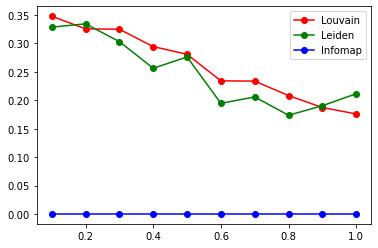

In [4]:
consts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
resultsLouvain = []
resultsLeiden = []
resultsInfomap = []
resultsGN = []

for c in tqdm(consts):
    mean = 10 * c
    shape = 10 * c/2
    grpGraph, comsGRP = GRP(500, mean, shape, 0.25, 0.1)
    
    grpLouvain = algorithms.louvain(grpGraph)
    grpLeiden = algorithms.leiden(grpGraph)
    grpInfomap = new_infomap(grpGraph, "-N 2")
    #grpGN = algorithms.girvan_newman(grpGraph, level=3)
    
    nmi1 = evaluation.normalized_mutual_information(grpLouvain, comsGRP)
    resultsLouvain.append(nmi1[0])
    nmi2 = evaluation.normalized_mutual_information(grpLeiden, comsGRP)
    resultsLeiden.append(nmi2[0])
    nmi3 =  evaluation.normalized_mutual_information(grpInfomap, comsGRP)
    resultsInfomap.append(nmi3[0])
    #nmi4 =  evaluation.normalized_mutual_information(grpGN, comsGRP)
    #resultsGN.append(nmi4[0])
    

plt.plot(consts,resultsLouvain, "-ro", label = "Louvain")
plt.plot(consts,resultsLeiden, "-go", label = "Leiden")
plt.plot(consts,resultsInfomap, "-bo", label = "Infomap")
#plt.plot(consts,resultsGN, "-yo", label = "Girvan-Newman")
plt.legend()
plt.show()

α
μ
